# Are there any UV selection effects from SDSS that can affect our results?

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
from galpopfm.catalogs import Catalog

# Read in SDSS UV data

In [4]:
sdss = Catalog('tinker')

In [6]:
# absolute magnitudes
abs_fuv, abs_nuv, _, abs_g, abs_r, _, _ = sdss.data['NSA_ABSMAG'].T

In [8]:
nmgy_fuv, nmgy_nuv = sdss.data['NSA_NMGY'][:,0], sdss.data['NSA_NMGY'][:,1]

In [9]:
# reconstructed nanomaggies from k-correct
rnmgy_fuv, rnmgy_nuv = sdss.data['NSA_RNMGY'][:,0], sdss.data['NSA_RNMGY'][:,1]

# FUV, NUV flux

(0.1, 100000.0)

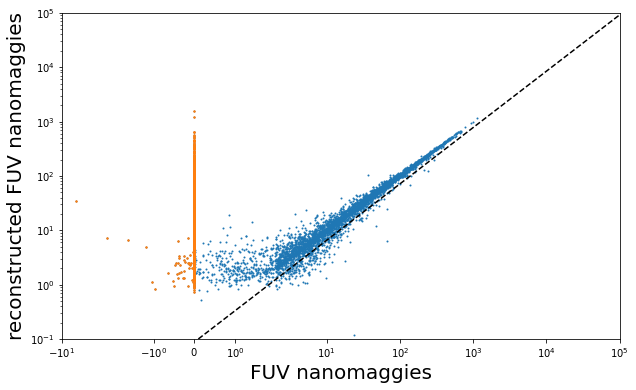

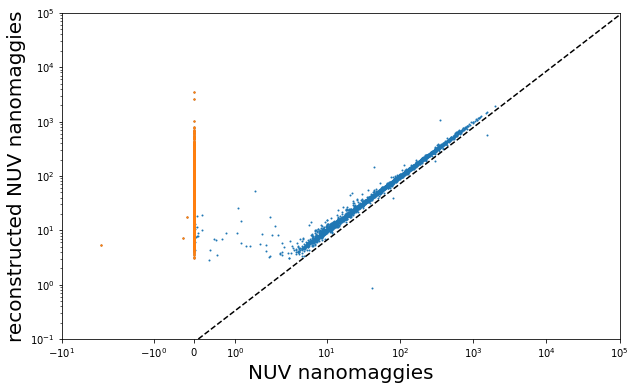

In [10]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_fuv[abs_r < -20], rnmgy_fuv[abs_r < -20], c='C0', s=1)
sub.scatter(nmgy_fuv[(abs_r < -20) & (nmgy_fuv <= 0)], rnmgy_fuv[(abs_r < -20) & (nmgy_fuv <= 0)], c='C1', s=2)
sub.plot([1e-1, 1e6], [1e-1, 1e6], c='k', ls='--')
sub.set_xlabel('FUV nanomaggies', fontsize=20)
sub.set_xscale('symlog')
sub.set_xlim(-1e1, 1e5)
sub.set_ylabel('reconstructed FUV nanomaggies', fontsize=20)
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e5)

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_nuv[abs_r < -20], rnmgy_nuv[abs_r < -20], c='C0', s=1)
sub.scatter(nmgy_nuv[(abs_r < -20) & (nmgy_nuv <= 0)], rnmgy_nuv[(abs_r < -20) & (nmgy_nuv <= 0)], c='C1', s=2)
sub.plot([1e-1, 1e6], [1e-1, 1e6], c='k', ls='--')
sub.set_xlabel('NUV nanomaggies', fontsize=20)
sub.set_xscale('symlog')
sub.set_xlim(-1e1, 1e5)
sub.set_ylabel('reconstructed NUV nanomaggies', fontsize=20)
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e5)

Ideally, we'd want to see very low reconstructed UV fluxes when the measured UV fluxes are low. However, it seems that there is little correlation between $FUV, NUV < 0$ and the K-correct reconstructed UV fluxes.

## Lets see how UV nondetections affect k-corrected absolute magnitudes

(-25.0, 0.0)

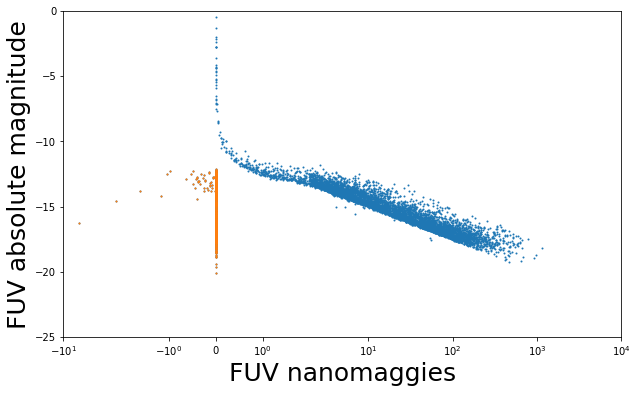

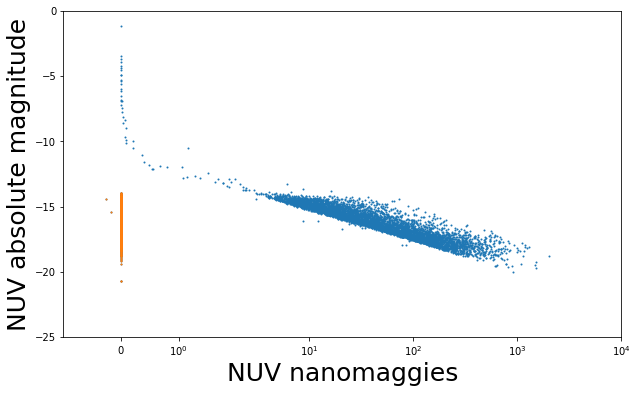

In [14]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_fuv[(abs_r < -20)], abs_fuv[(abs_r < -20)], c='C0', s=1)
sub.scatter(nmgy_fuv[(abs_r < -20) & (nmgy_fuv <= 0)], abs_fuv[(abs_r < -20) & (nmgy_fuv <= 0)], c='C1', s=1)
sub.set_xlabel('FUV nanomaggies', fontsize=25)
sub.set_xscale('symlog')
sub.set_xlim(-10, 1e4)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)
sub.set_ylim(-25, 0)

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_nuv[(abs_r < -20)], abs_nuv[(abs_r < -20)], c='C0', s=1)
sub.scatter(nmgy_nuv[(abs_r < -20) & (nmgy_nuv <= 0)], abs_nuv[(abs_r < -20) & (nmgy_nuv <= 0)], c='C1', s=1)
sub.set_xlabel('NUV nanomaggies', fontsize=25)
sub.set_xscale('symlog')
sub.set_xlim(-1, 1e4)
sub.set_ylabel('NUV absolute magnitude', fontsize=25)
sub.set_ylim(-25, 0)

In [15]:
nondetect = (nmgy_nuv <= 0) | (nmgy_fuv <= 0)

Text(0.5, 1.0, 'non-detections')

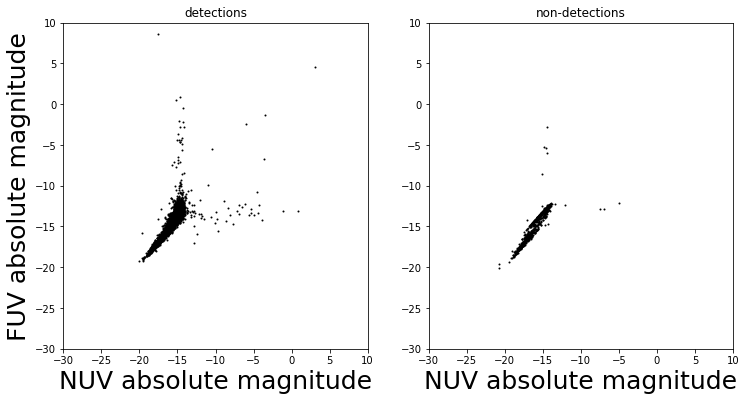

In [16]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(abs_nuv[(abs_r < -20) & ~nondetect], abs_fuv[(abs_r < -20) & ~nondetect], c='k', s=1)
sub.set_xlabel('NUV absolute magnitude', fontsize=25)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)
sub.set_xlim([-30., 10])
sub.set_ylim([-30., 10])
sub.set_title('detections')

sub = fig.add_subplot(122)
sub.scatter(abs_nuv[(abs_r < -20) & nondetect], abs_fuv[(abs_r < -20) & nondetect], c='k', s=1)
sub.set_xlabel('NUV absolute magnitude', fontsize=25)
sub.set_xlim([-30., 10])
sub.set_ylim([-30., 10])
sub.set_title('non-detections')

# Lets see how nondetections impact $FUV - NUV$ color-magnitude relation

(-1.0, 4.0)

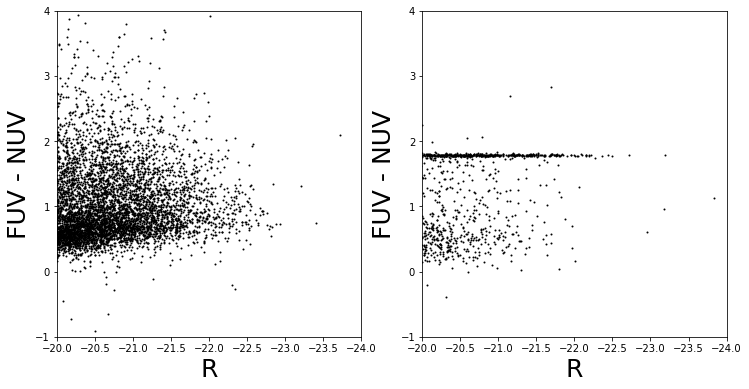

In [17]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.scatter(abs_r[~nondetect], (abs_fuv - abs_nuv)[~nondetect], c='k', s=1)
sub.set_xlabel('R', fontsize=25)
sub.set_xlim(-20, -24)
sub.set_ylabel('FUV - NUV', fontsize=25)
sub.set_ylim(-1., 4)

sub = fig.add_subplot(122)
sub.scatter(abs_r[nondetect], (abs_fuv - abs_nuv)[nondetect], c='k', s=1)
sub.set_xlabel('R', fontsize=25)
sub.set_xlim(-20, -24)
sub.set_ylabel('FUV - NUV', fontsize=25)
sub.set_ylim(-1., 4)

# FUV, NUV absolute magnitude cut
Based on the UV fluxes, we should impose an absolute magnitude cut for the observations and simulations

(-25.0, 0.0)

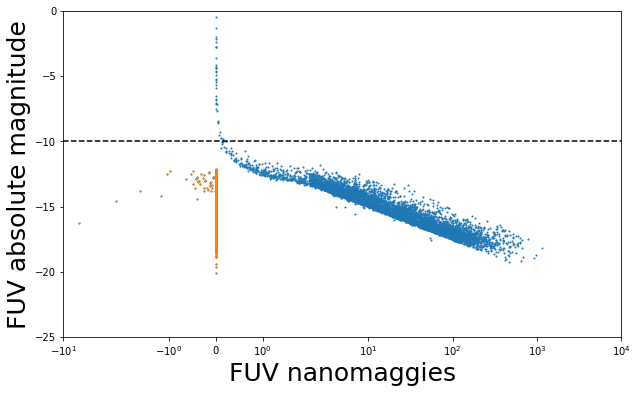

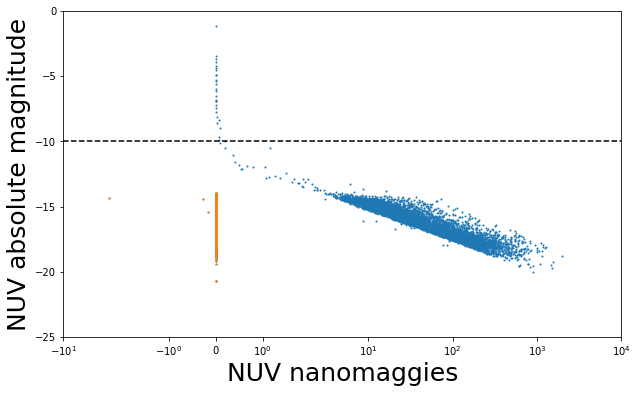

In [19]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_fuv[(abs_r < -20)], abs_fuv[(abs_r < -20)], c='C0', s=1)
sub.scatter(nmgy_fuv[(abs_r < -20) & (nmgy_fuv <= 0)], abs_fuv[(abs_r < -20) & (nmgy_fuv <= 0)], c='C1', s=1)
sub.axhline(-10, color='k', linestyle='--')
sub.set_xlabel('FUV nanomaggies', fontsize=25)
sub.set_xscale('symlog')
sub.set_xlim(-10, 1e4)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)
sub.set_ylim(-25, 0)


fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_nuv[(abs_r < -20)], abs_nuv[(abs_r < -20)], c='C0', s=1)
sub.scatter(nmgy_nuv[(abs_r < -20) & (nmgy_nuv <= 0)], abs_nuv[(abs_r < -20) & (nmgy_nuv <= 0)], c='C1', s=1)
sub.axhline(-10, color='k', linestyle='--')

sub.set_xlabel('NUV nanomaggies', fontsize=25)
sub.set_xscale('symlog')
sub.set_xlim(-10, 1e4)
sub.set_ylabel('NUV absolute magnitude', fontsize=25)
sub.set_ylim(-25, 0)

In [20]:
uv_mag_cut = (abs_fuv < -10) & (abs_nuv < -10) & ~nondetect

(-1.0, 4.0)

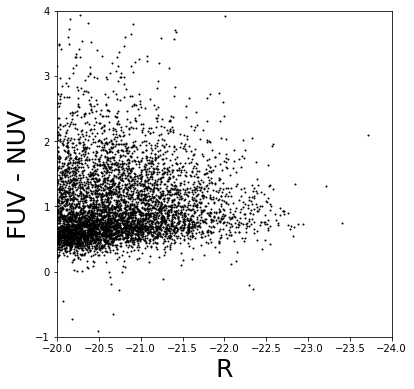

In [21]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(abs_r[uv_mag_cut], (abs_fuv - abs_nuv)[uv_mag_cut], c='k', s=1)
sub.set_xlabel('R', fontsize=25)
sub.set_xlim(-20, -24)
sub.set_ylabel('FUV - NUV', fontsize=25)
sub.set_ylim(-1., 4)

(0.1, 100000.0)

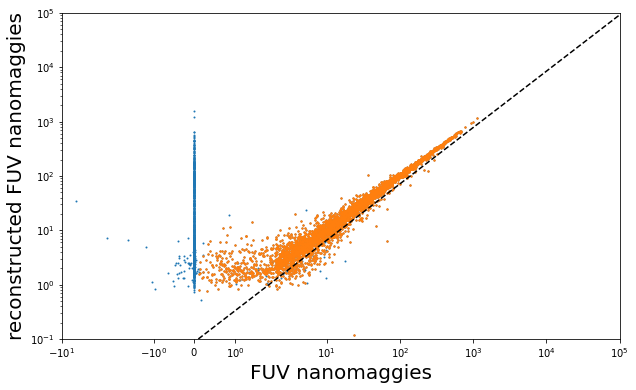

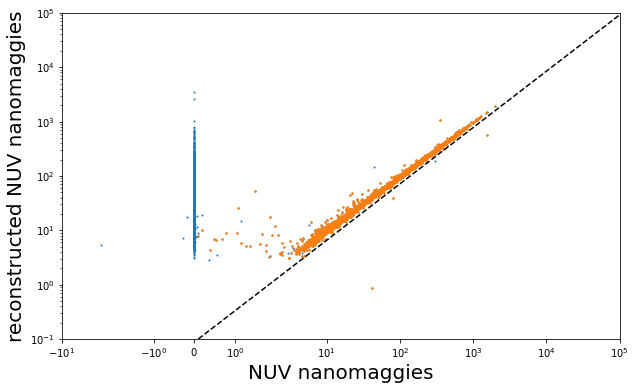

In [22]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_fuv[abs_r < -20], rnmgy_fuv[abs_r < -20], c='C0', s=1)
sub.scatter(nmgy_fuv[(abs_r < -20) & uv_mag_cut], rnmgy_fuv[(abs_r < -20) & uv_mag_cut], c='C1', s=2)
sub.plot([1e-1, 1e6], [1e-1, 1e6], c='k', ls='--')
sub.set_xlabel('FUV nanomaggies', fontsize=20)
sub.set_xscale('symlog')
sub.set_xlim(-1e1, 1e5)
sub.set_ylabel('reconstructed FUV nanomaggies', fontsize=20)
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e5)

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_nuv[abs_r < -20], rnmgy_nuv[abs_r < -20], c='C0', s=1)
sub.scatter(nmgy_nuv[(abs_r < -20) & uv_mag_cut], rnmgy_nuv[(abs_r < -20) & uv_mag_cut], c='C1', s=2)
sub.plot([1e-1, 1e6], [1e-1, 1e6], c='k', ls='--')
sub.set_xlabel('NUV nanomaggies', fontsize=20)
sub.set_xscale('symlog')
sub.set_xlim(-1e1, 1e5)
sub.set_ylabel('reconstructed NUV nanomaggies', fontsize=20)
sub.set_yscale('log')
sub.set_ylim(1e-1, 1e5)

# Lets see how this impacts the simulations

In [23]:
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs


def fm(sim, theta): 
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 

    mlim    = np.ones(len(_sim_sed['logmstar'])).astype(bool)#(_sim_sed['logmstar'] > 9.4) 
    zerosfr = (_sim_sed['logsfr.inst'] == -999)
    cuts    = mlim 

    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'][cuts].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cuts].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cuts,:][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 
    
    sed_dusty = dustFM.Attenuate(
        theta, 
        sim_sed['wave'], 
        sim_sed['sed_noneb'], 
        sim_sed['sed_onlyneb'], 
        sim_sed['logmstar'],
        sim_sed['logsfr.inst'],
        dem='slab_noll_mssfr_fixbump') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    G_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='g_sdss') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 

    return F_mag, N_mag, G_mag, R_mag

In [24]:
F_eag, N_eag, G_eag, R_eag = fm('eagle', np.zeros(6))
F_tng, N_tng, G_tng, R_tng = fm('tng', np.zeros(6))
F_sim, N_sim, G_sim, R_sim = fm('simba', np.zeros(6))

In [25]:
eag_cut = (R_eag < -20)
tng_cut = (R_tng < -20)
sim_cut = (R_sim < -20)

eag_uv_cut = (F_eag < -10) & (N_eag < -10) & (R_eag < -20)
tng_uv_cut = (F_tng < -10) & (N_tng < -10) & (R_tng < -20)
sim_uv_cut = (F_sim < -10) & (N_sim < -10) & (R_sim < -20)

print("%i of %i galaxies included in EAGLE" % (np.sum(eag_uv_cut), np.sum(eag_cut)))
print("%i of %i galaxies included in TNG" % (np.sum(tng_uv_cut), np.sum(tng_cut)))
print("%i of %i galaxies included in SIMBA" % (np.sum(sim_uv_cut), np.sum(sim_cut)))

3383 of 3383 galaxies included in EAGLE
6461 of 6461 galaxies included in TNG
14550 of 14550 galaxies included in SIMBA


Without dust, there are no simulated galaxies below the UV absolute magnitude limit